# Reconstructing LMRv2.1 with cfr

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

octave not found, please see README
2024.11.6


## Load Data

### Load proxies

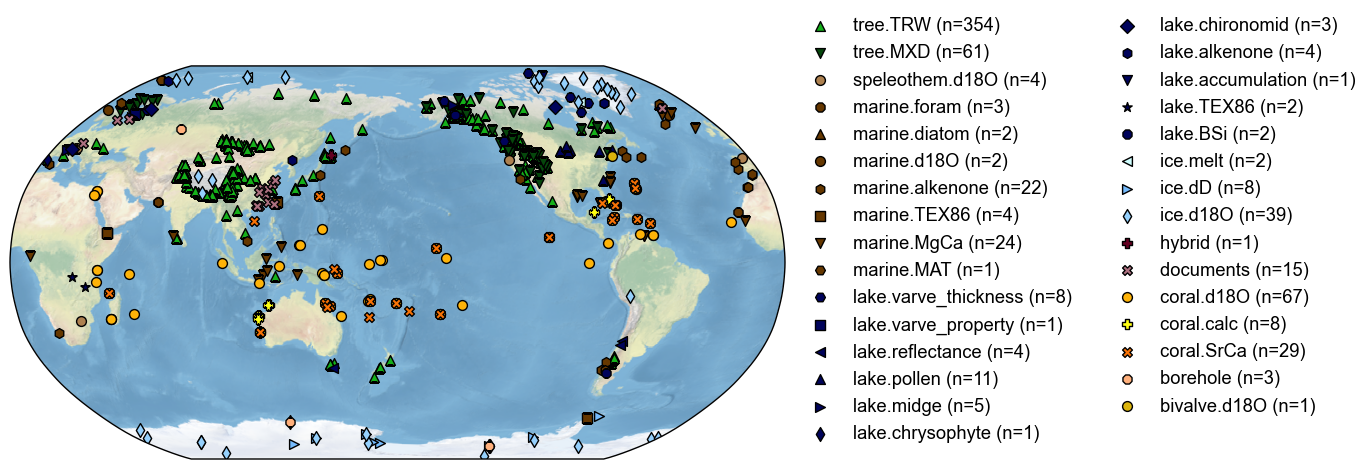

In [2]:
job = cfr.ReconJob()
job.load_proxydb('PAGES2kv2')

fig, ax = job.proxydb.plot() # plot to check

### Load model prior (CMIP5 CCSM4 last1000 simulated tas and pr fields)

In [4]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # Tardif 2019 uses entire interval
    load=True,  
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc', 'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'}
>>> job.configs["prior_anom_period"] = [850, 1850]
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


In [5]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)


After initial load:
Shape: (12012, 192, 288)
Contains NaN? False
Sample values from first timestep:
[[ 4.2724609e-04 -1.4116669e+00 -1.4149780e+00 -7.6078796e-01
  -1.3295441e+00]
 [ 2.8004456e-01  2.4789429e-01  3.3767700e-01 -5.2047729e-02
   3.3233643e-01]
 [ 4.6669006e-01 -1.6618347e-01  5.8181763e-01 -2.5801086e-01
   2.7944946e-01]
 [ 3.3268738e-01  3.2659912e-01  3.8771057e-01  4.2834473e-01
   6.8528748e-01]
 [ 3.4626770e-01  3.5942078e-01  6.5942383e-01  1.0366669e+00
   7.7363586e-01]]


### Load instrumental observations

In [8]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], 
    load=True,
    verbose = True
)

>>> job.configs["obs_path"] = {'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc', 'tas': 'gistemp1200_ERSSTv4'}
>>> job.configs["obs_rename_dict"] = {'pr': 'precip', 'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> The target file seems existed at: ./data/gistemp1200_ERSSTv4.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['pr', 'tas'] loaded
>>> job.obs created


## Calibrate PSM

In [10]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# target variables
ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'ice.d18O': ['tas'],
    'lake.varve_thickness': ['tas'],
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        #[1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

In [11]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    nobs_lb = 25,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'ice.melt': 'Linear', 'marine.foram': 'Linear', 'marine.alkenone': 'Linear', 'tree.TRW': 'Bilinear', 'lake.varve_thickness': 'Linear', 'lake.chironomid': 'Linear', 'lake.pollen': 'Linear', 'coral.calc': 'Linear', 'marine.TEX86': 'Linear', 'lake.varve_property': 'Linear', 'marine.MgCa': 'Linear', 'coral.SrCa': 'Linear', 'marine.diatom': 'Linear', 'lake.midge': 'Linear', 'coral.d18O': 'Linear', 'hybrid': 'Linear', 'marine.MAT': 'Linear', 'lake.accumulation': 'Linear', 'lake.chrysophyte': 'Linear', 'lake.TEX86': 'Linear', 'tree.MXD': 'Linear', 'lake.reflectance': 'Linear', 'marine.d18O': 'Linear', 'documents': 'Linear', 'borehole': 'Linear', 'ice.dD': 'Linear', 'speleothem.d18O': 'Linear', 'bivalve.d18O': 'Linear', 'lake.BSi': 'Linear', 'lake.alkenone': 'Linear', 'ice.d18O': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'marine.foram': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'marine.alkenone': [

Calibrating the PSMs:   0%|          | 1/692 [00:02<25:54,  2.25s/it]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:   1%|          | 8/692 [00:09<14:11,  1.24s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   2%|▏         | 12/692 [00:11<10:25,  1.09it/s]

The number of overlapped data points is 7 < 25. Skipping ...


Calibrating the PSMs:   2%|▏         | 15/692 [00:13<08:29,  1.33it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   3%|▎         | 21/692 [00:20<12:16,  1.10s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   4%|▎         | 25/692 [00:25<14:03,  1.26s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   4%|▍         | 29/692 [00:30<14:12,  1.29s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:   5%|▍         | 32/692 [00:31<10:03,  1.09it/s]

The number of overlapped data points is 9 < 25. Skipping ...
The number of overlapped data points is 15 < 25. Skipping ...


Calibrating the PSMs:   5%|▌         | 35/692 [00:33<08:26,  1.30it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   6%|▌         | 41/692 [00:41<13:53,  1.28s/it]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:   7%|▋         | 51/692 [00:51<09:52,  1.08it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   8%|▊         | 54/692 [00:53<07:52,  1.35it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   8%|▊         | 57/692 [00:55<07:02,  1.50it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:   9%|▉         | 64/692 [01:00<05:52,  1.78it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  10%|▉         | 68/692 [01:03<07:41,  1.35it/s]

Asi_117 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_117 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  11%|█         | 73/692 [01:11<14:00,  1.36s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  11%|█         | 77/692 [01:14<10:57,  1.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  11%|█▏        | 79/692 [01:16<10:00,  1.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  12%|█▏        | 82/692 [01:19<10:43,  1.05s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  13%|█▎        | 89/692 [01:27<10:40,  1.06s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 11 < 25. Skipping ...


Calibrating the PSMs:  14%|█▍        | 96/692 [01:33<09:01,  1.10it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  15%|█▍        | 102/692 [01:38<08:41,  1.13it/s]

The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  16%|█▌        | 112/692 [01:44<05:33,  1.74it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  17%|█▋        | 120/692 [01:53<10:08,  1.06s/it]

The number of overlapped data points is 20 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...


Calibrating the PSMs:  18%|█▊        | 126/692 [01:56<07:03,  1.34it/s]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  18%|█▊        | 128/692 [01:58<07:25,  1.27it/s]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  19%|█▉        | 133/692 [02:00<04:51,  1.92it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  20%|█▉        | 136/692 [02:04<07:23,  1.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  20%|██        | 140/692 [02:07<08:09,  1.13it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  21%|██        | 146/692 [02:14<11:25,  1.25s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  22%|██▏       | 149/692 [02:18<11:19,  1.25s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs:  22%|██▏       | 151/692 [02:20<10:05,  1.12s/it]

The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs:  22%|██▏       | 153/692 [02:22<09:39,  1.08s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 160/692 [02:26<05:28,  1.62it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  24%|██▎       | 163/692 [02:31<09:59,  1.13s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  24%|██▍       | 168/692 [02:37<11:55,  1.36s/it]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  25%|██▌       | 173/692 [02:39<05:22,  1.61it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 4 < 25. Skipping ...
The number of overlapped data points is 24 < 25. Skipping ...


Calibrating the PSMs:  28%|██▊       | 194/692 [02:52<04:36,  1.80it/s]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  30%|██▉       | 207/692 [03:04<08:45,  1.08s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  30%|███       | 209/692 [03:06<07:57,  1.01it/s]

The number of overlapped data points is 21 < 25. Skipping ...


Calibrating the PSMs:  31%|███       | 213/692 [03:10<07:06,  1.12it/s]

The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  31%|███       | 215/692 [03:11<07:02,  1.13it/s]

The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  34%|███▎      | 232/692 [03:30<09:10,  1.20s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  34%|███▍      | 236/692 [03:34<07:57,  1.05s/it]

The number of overlapped data points is 11 < 25. Skipping ...


Calibrating the PSMs:  35%|███▍      | 239/692 [03:36<06:16,  1.20it/s]

The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  35%|███▍      | 242/692 [03:37<05:27,  1.37it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  36%|███▌      | 246/692 [03:39<04:36,  1.61it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  36%|███▌      | 250/692 [03:43<05:53,  1.25it/s]

The number of overlapped data points is 21 < 25. Skipping ...


Calibrating the PSMs:  37%|███▋      | 256/692 [03:50<08:01,  1.11s/it]

The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  38%|███▊      | 262/692 [03:52<03:49,  1.87it/s]

The number of overlapped data points is 18 < 25. Skipping ...


Calibrating the PSMs:  38%|███▊      | 264/692 [03:55<06:27,  1.11it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  39%|███▉      | 273/692 [04:01<05:34,  1.25it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  40%|███▉      | 275/692 [04:02<05:38,  1.23it/s]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  40%|████      | 280/692 [04:04<03:25,  2.00it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  42%|████▏     | 289/692 [04:15<08:35,  1.28s/it]

The number of overlapped data points is 5 < 25. Skipping ...


Calibrating the PSMs:  42%|████▏     | 294/692 [04:18<06:26,  1.03it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  43%|████▎     | 296/692 [04:20<06:05,  1.08it/s]

The number of overlapped data points is 11 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  44%|████▍     | 304/692 [04:24<03:19,  1.94it/s]

The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  44%|████▍     | 306/692 [04:26<04:30,  1.43it/s]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  45%|████▍     | 308/692 [04:27<04:47,  1.34it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  45%|████▌     | 312/692 [04:31<05:37,  1.13it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  46%|████▌     | 320/692 [04:36<03:50,  1.61it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  47%|████▋     | 328/692 [04:44<04:18,  1.41it/s]

The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 22 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  49%|████▉     | 342/692 [04:54<03:30,  1.67it/s]

The number of overlapped data points is 1 < 25. Skipping ...
The number of overlapped data points is 19 < 25. Skipping ...


Calibrating the PSMs:  50%|████▉     | 344/692 [04:56<04:12,  1.38it/s]

The number of overlapped data points is 4 < 25. Skipping ...


Calibrating the PSMs:  50%|█████     | 346/692 [04:56<03:03,  1.88it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 16 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  51%|█████▏    | 355/692 [05:01<03:33,  1.58it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  54%|█████▎    | 371/692 [05:23<06:28,  1.21s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  55%|█████▍    | 378/692 [05:31<06:55,  1.32s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  56%|█████▌    | 388/692 [05:38<02:55,  1.73it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  56%|█████▌    | 389/692 [05:38<02:32,  1.98it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  58%|█████▊    | 399/692 [05:51<06:51,  1.41s/it]

The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  58%|█████▊    | 401/692 [05:53<05:43,  1.18s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 5 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  59%|█████▉    | 411/692 [06:00<03:04,  1.53it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  60%|██████    | 416/692 [06:03<02:36,  1.76it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  61%|██████    | 420/692 [06:07<03:28,  1.31it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  62%|██████▏   | 426/692 [06:09<02:02,  2.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  62%|██████▏   | 428/692 [06:11<02:40,  1.65it/s]

Asi_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_111 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  62%|██████▏   | 429/692 [06:14<04:43,  1.08s/it]

The number of overlapped data points is 13 < 25. Skipping ...


Calibrating the PSMs:  63%|██████▎   | 437/692 [06:22<04:21,  1.02s/it]

The number of overlapped data points is 3 < 25. Skipping ...


Calibrating the PSMs:  64%|██████▎   | 440/692 [06:26<04:59,  1.19s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  64%|██████▍   | 442/692 [06:28<04:27,  1.07s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  66%|██████▌   | 454/692 [06:40<03:41,  1.08it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  66%|██████▋   | 459/692 [06:42<02:12,  1.75it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  67%|██████▋   | 464/692 [06:46<02:29,  1.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  68%|██████▊   | 474/692 [06:55<03:13,  1.12it/s]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  69%|██████▉   | 476/692 [06:56<03:09,  1.14it/s]

The number of overlapped data points is 21 < 25. Skipping ...


Calibrating the PSMs:  69%|██████▉   | 478/692 [06:58<03:12,  1.11it/s]

The number of overlapped data points is 5 < 25. Skipping ...


Calibrating the PSMs:  70%|███████   | 485/692 [07:09<05:12,  1.51s/it]

The number of overlapped data points is 7 < 25. Skipping ...


Calibrating the PSMs:  72%|███████▏  | 497/692 [07:21<04:28,  1.38s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  73%|███████▎  | 505/692 [07:33<05:01,  1.61s/it]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 8 < 25. Skipping ...


Calibrating the PSMs:  74%|███████▍  | 515/692 [07:40<01:44,  1.69it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  76%|███████▋  | 528/692 [07:54<03:59,  1.46s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  77%|███████▋  | 531/692 [07:56<02:36,  1.03it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  77%|███████▋  | 533/692 [07:57<02:26,  1.08it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  77%|███████▋  | 536/692 [08:01<02:40,  1.03s/it]

The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  78%|███████▊  | 540/692 [08:01<01:20,  1.88it/s]

The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs:  79%|███████▉  | 549/692 [08:07<01:13,  1.96it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  80%|███████▉  | 552/692 [08:07<00:43,  3.21it/s]

The number of overlapped data points is 8 < 25. Skipping ...
The number of overlapped data points is 3 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 2 < 25. Skipping ...
The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  80%|████████  | 556/692 [08:10<01:23,  1.63it/s]

The number of overlapped data points is 17 < 25. Skipping ...


Calibrating the PSMs:  81%|████████  | 558/692 [08:12<01:31,  1.46it/s]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  81%|████████  | 561/692 [08:15<01:58,  1.10it/s]

The number of overlapped data points is 2 < 25. Skipping ...


Calibrating the PSMs:  83%|████████▎ | 571/692 [08:26<02:17,  1.14s/it]

The number of overlapped data points is 2 < 25. Skipping ...


Calibrating the PSMs:  83%|████████▎ | 576/692 [08:33<02:47,  1.44s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  86%|████████▌ | 592/692 [08:58<02:53,  1.73s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  86%|████████▌ | 594/692 [09:00<02:11,  1.34s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  86%|████████▋ | 597/692 [09:01<01:32,  1.02it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  87%|████████▋ | 599/692 [09:03<01:27,  1.06it/s]

The number of overlapped data points is 4 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...
The number of overlapped data points is 6 < 25. Skipping ...


Calibrating the PSMs:  88%|████████▊ | 611/692 [09:12<00:55,  1.46it/s]

The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 14 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  89%|████████▊ | 614/692 [09:14<00:53,  1.46it/s]

Asi_118 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_118 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  89%|████████▉ | 616/692 [09:18<01:25,  1.13s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  89%|████████▉ | 618/692 [09:20<01:16,  1.03s/it]

The number of overlapped data points is 1 < 25. Skipping ...


Calibrating the PSMs:  90%|████████▉ | 620/692 [09:21<01:09,  1.03it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  91%|█████████ | 628/692 [09:30<01:08,  1.07s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  92%|█████████▏| 635/692 [09:41<01:30,  1.59s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  93%|█████████▎| 646/692 [09:52<00:48,  1.06s/it]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  95%|█████████▍| 657/692 [10:03<00:34,  1.01it/s]

The number of overlapped data points is 9 < 25. Skipping ...


Calibrating the PSMs:  96%|█████████▌| 665/692 [10:09<00:16,  1.60it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 12 < 25. Skipping ...


Calibrating the PSMs:  96%|█████████▌| 666/692 [10:11<00:22,  1.18it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  97%|█████████▋| 670/692 [10:13<00:14,  1.55it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  99%|█████████▊| 682/692 [10:27<00:11,  1.16s/it]

Asi_119 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_119 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_119 >>> Found nearest climate within distance of 2 deg.


Calibrating the PSMs:  99%|█████████▊| 683/692 [10:32<00:18,  2.09s/it]

The number of overlapped data points is 10 < 25. Skipping ...


Calibrating the PSMs: 100%|██████████| 692/692 [10:37<00:00,  1.09it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...
>>> PSM for Asi_245 failed to be calibrated.
>>> PSM for Arc_070 failed to be calibrated.
>>> PSM for Asi_242 failed to be calibrated.
>>> PSM for Ant_023 failed to be calibrated.
>>> PSM for Arc_042 failed to be calibrated.
>>> PSM for Ocn_075 failed to be calibrated.
>>> PSM for Ocn_018 failed to be calibrated.
>>> PSM for Asi_239 failed to be calibrated.
>>> PSM for Ocn_011 failed to be calibrated.
>>> PSM for Ocn_052 failed to be calibrated.
>>> PSM for NAm_073 failed to be calibrated.
>>> PSM for Ocn_091 failed to be calibrated.
>>> PSM for Ocn_093 failed to be calibrated.
>>> PSM for Ocn_045 failed to be calibrated.
>>> PSM for Ant_024 failed to be calibrated.
>>> PSM for Ocn_004 failed to be calibrated.
>>> PSM for Ocn_096 failed to be calibrated.
>>> PSM for NAm_068 failed to be calibrated.
>>> PSM

### Run PSMs

In [12]:
job.forward_psms(verbose=True)

>>> job.configs["ptype_forward_dict"] = {}


Forwarding the PSMs: 100%|██████████| 519/519 [02:37<00:00,  3.30it/s]

>>> ProxyRecord.pseudo created for 519 records


### Annualize and Regrid model prior fields

In [13]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

In [14]:
job.save('./cases/lmr_reproduce_pda', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/lmr_reproduce_pda
>>> prior_tas saved to: ./cases/lmr_reproduce_pda/prior_tas.nc
>>> prior_pr saved to: ./cases/lmr_reproduce_pda/prior_pr.nc
>>> obs_pr saved to: ./cases/lmr_reproduce_pda/obs_pr.nc
>>> obs_tas saved to: ./cases/lmr_reproduce_pda/obs_tas.nc
>>> job saved to: ./cases/lmr_reproduce_pda/job.pkl


## Run DA solver

In [23]:
job.run_da_mc(
    save_dirpath='./recons/lmr_reproduce_pda',
    recon_seeds=list(range(1, 2)),  # as an example here
    recon_vars=['tas','pr'],  # running tas and pr even though paper mainly focuses on tas
    recon_period=[1, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [1, 2000]
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["recon_seeds"] = [1]
>>> job.configs["save_dirpath"] = ./recons/lmr_reproduce_pda
>>> seed: 1 | max: 1


KF updating: 100%|██████████| 2000/2000 [27:00<00:00,  1.23it/s]


>>> Reconstructed fields saved to: ./recons/lmr_reproduce_pda/job_r01_recon.nc
>>> DONE! Total time spent: 29.58 mins.


In [24]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda/')

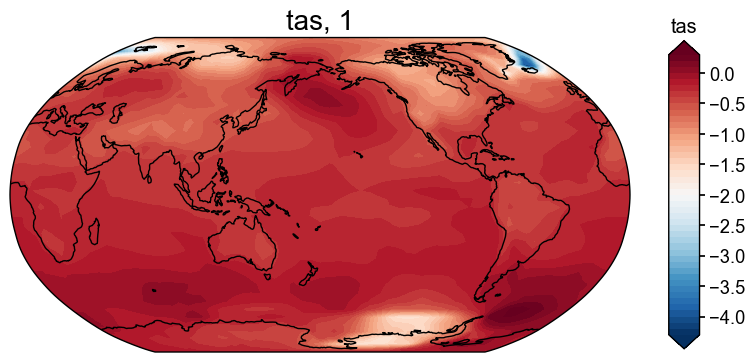

In [25]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot()

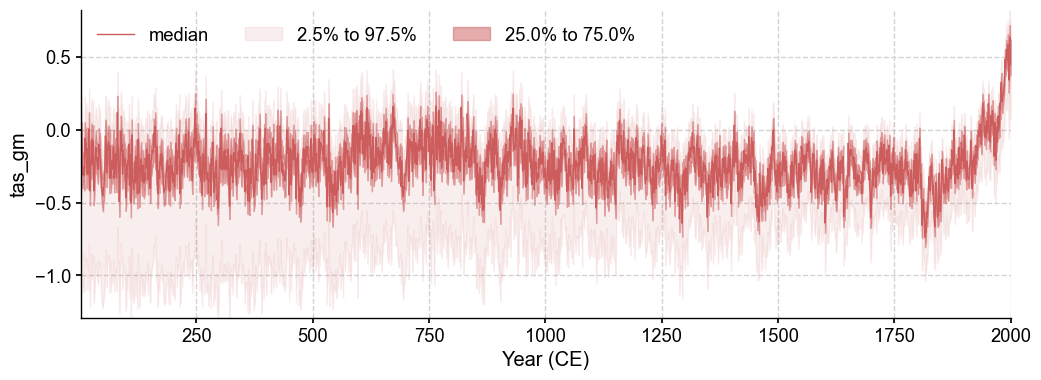

In [26]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

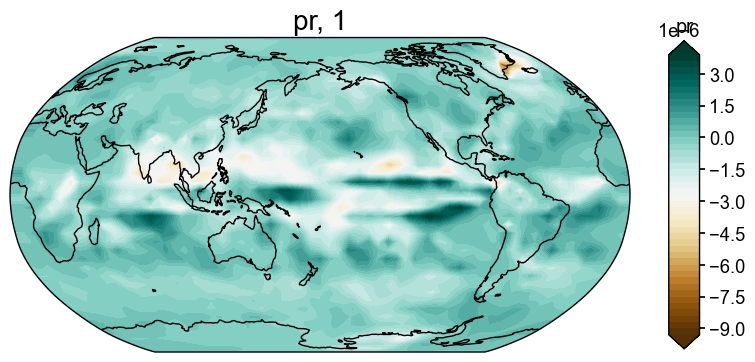

In [27]:
fig, ax = res.recons['pr'].plot()

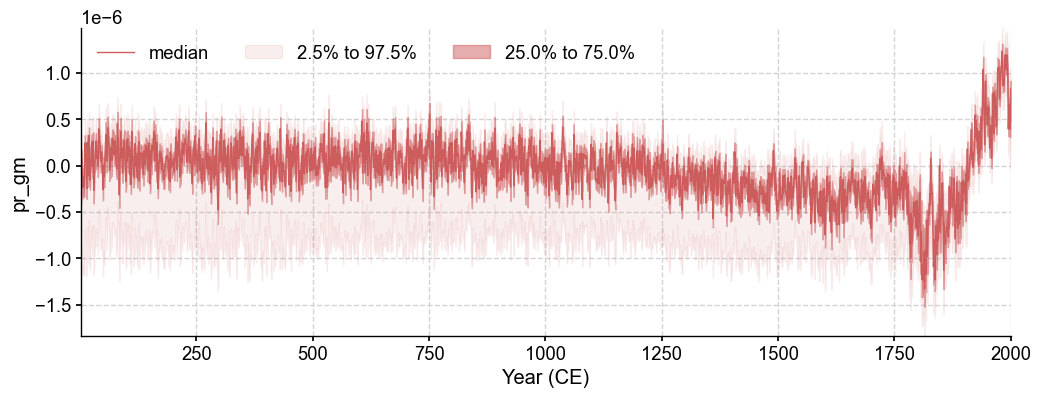

In [32]:
fig, ax = res.recons['pr_gm'].plot_qs()